In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.join('..'))
from counting_boats.boat_utils import spatial_helpers 

COVERAGE_PATH       = "C:\\ML_Software\\All_Results\\coverage.csv"
DETECTIONS_PATH     = "C:\\ML_Software\\All_Results\\boat_detections.csv"
ORDERS_PATH         = "C:\\ML_Software\\All_Results\\orders.csv"
UDM_FOLDER          = "D:\\Results\\UDM\\"

In [29]:
coverage = pd.read_csv(COVERAGE_PATH)
coverage['date'] = pd.to_datetime(coverage['date'])
detections = pd.read_csv(DETECTIONS_PATH)
detections['date'] = pd.to_datetime(detections['date'])
orders = pd.read_csv(ORDERS_PATH)
orders['date'] = pd.to_datetime(orders['date'], format="mixed", dayfirst=True)

Year range: 2016-07-03T00:00:00.000000000 to 2024-06-30T00:00:00.000000000


C:\Users\turner30\AppData\Local\Temp\ipykernel_13380\3225334021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cov[all_cov["area_coverage"] > 1.0]["area_coverage"] = 1.0


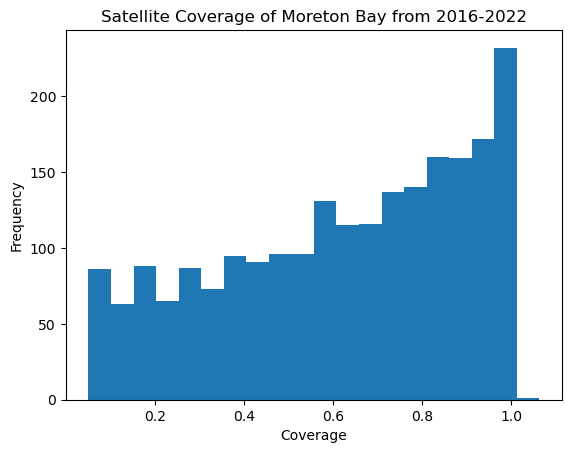

In [30]:
all_cov = coverage[coverage['area_coverage'] > 0.05]
all_cov[all_cov["area_coverage"] > 1.0]["area_coverage"] = 1.0

all_cov = all_cov['area_coverage'].values

year_min = min(coverage['date'].values)
year_max = max(coverage['date'].values)
print(f"Year range: {year_min} to {year_max}")


# plot a histogram of the coverage
plt.hist(all_cov, bins=20)
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Satellite Coverage of Moreton Bay from 2016-2022')
plt.show()


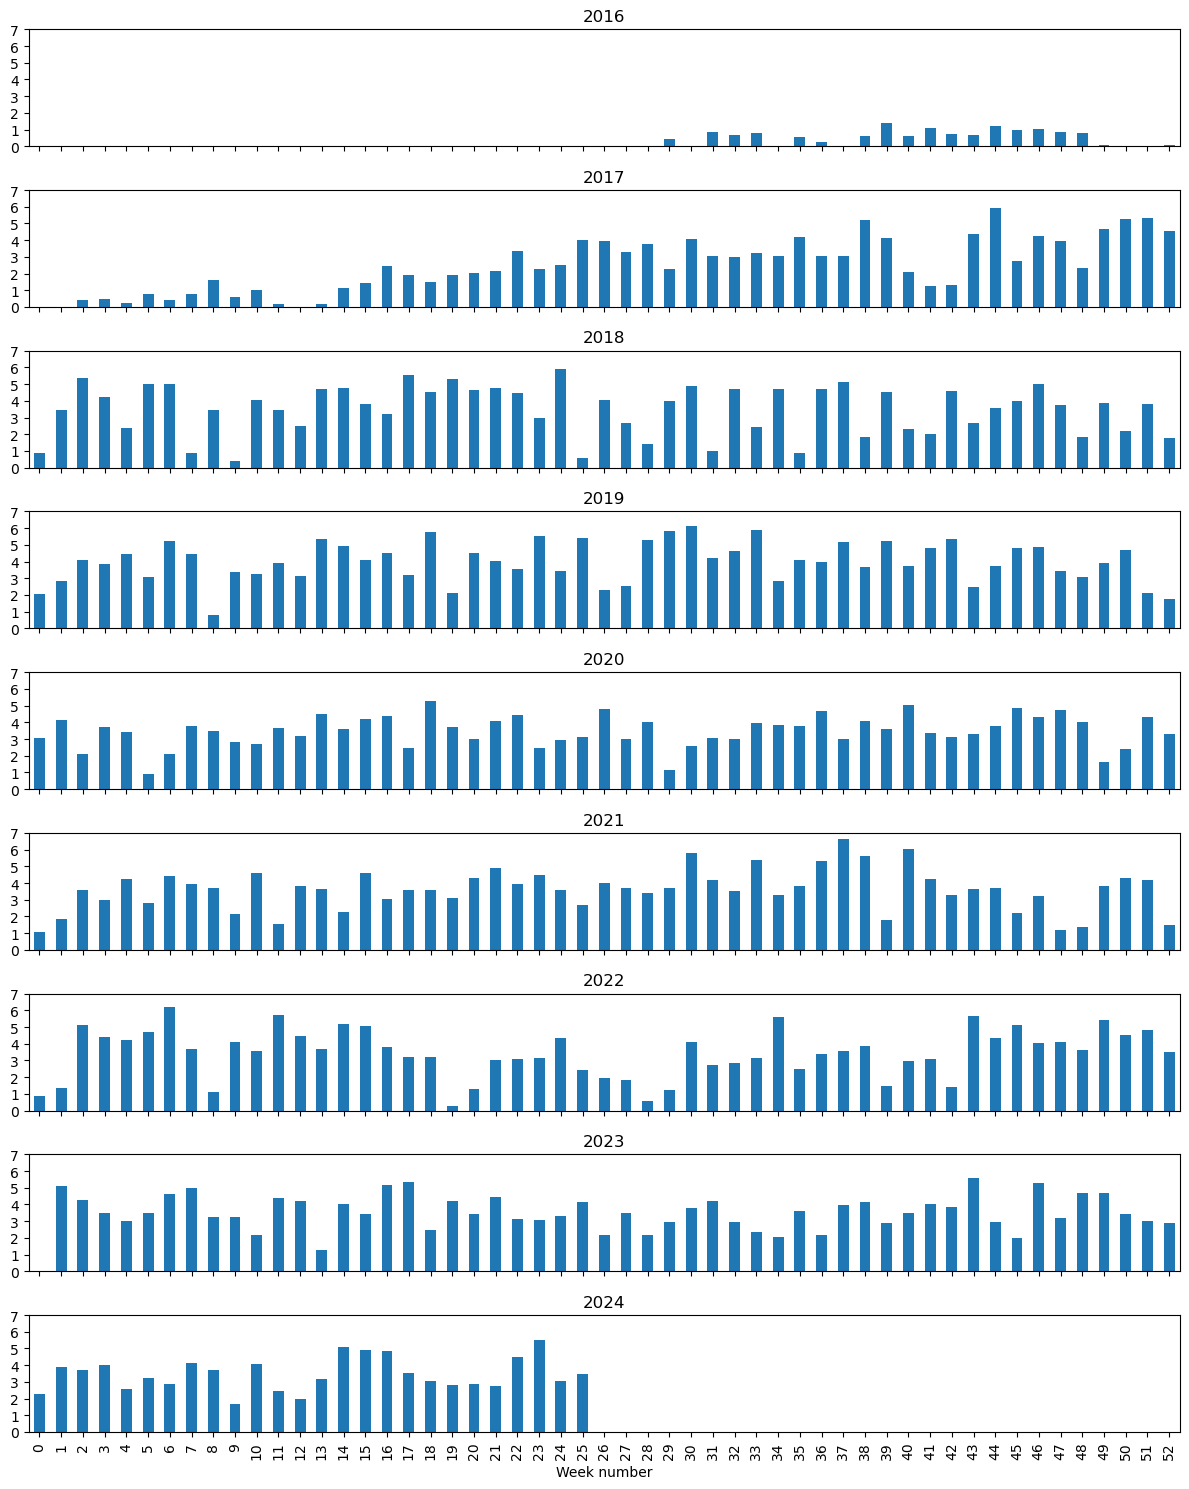

In [41]:
# bar chart of images per week
coverage["year"] = coverage["date"].dt.year
coverage["week"] = coverage["date"].dt.strftime("%U").astype(int)
# bar chart of coverage per week (e.g images scaled by coverage value)


fig = plt.figure(figsize=(12, 15))
axes = fig.subplots(9, 1, sharex=True)
# make sure x axis is from 0 to 52

for year in range(2016, 2024 + 1):
    ax = axes[year - 2016]
    # we want to make sure we have 0 to 52, even if some weeks are missing
    coverage[coverage["date"].dt.year == year].groupby("week")["area_coverage"].sum().reindex(range(0, 53), fill_value=0).plot(kind='bar', ylim=(0, 7), xlim=(0, 53), ax=ax)
    ax.title.set_text(f"{year}")
    ax.set_yticks(range(0, 8))
# xlabel week number
plt.xlabel("Week number")
plt.tight_layout()
plt.show()

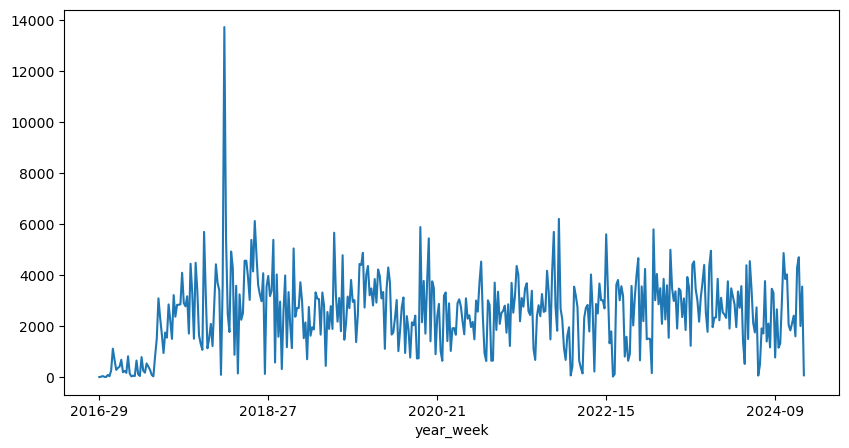

In [33]:
# plot detections/week
figure = plt.figure(figsize=(10, 5))
detections["year_week"] = detections["date"].dt.strftime('%Y-%U')
detections["year_week"].value_counts().sort_index().plot()
plt.show()


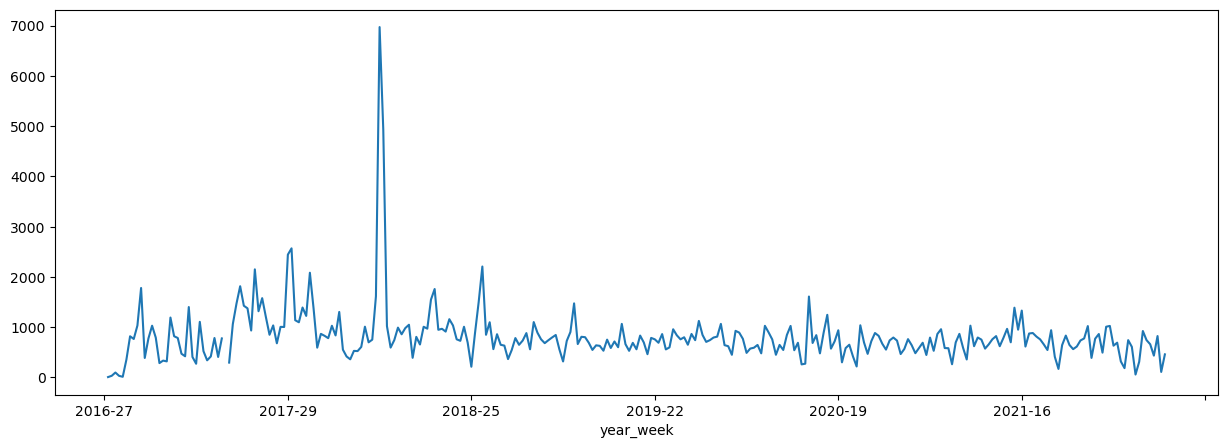

In [7]:
# plot detections divided by coverage over time
detections["year_week"] = detections["date"].dt.strftime('%Y-%U')
weekly_counts = detections["year_week"].value_counts()
weekly_counts = weekly_counts.sort_index()
coverage["year_week"] = coverage["date"].dt.strftime('%Y-%U')
normalized_counts_weekly = weekly_counts / coverage.groupby("year_week")["area_coverage"].sum()
normalized_counts_weekly.plot(figsize=(15, 5))
plt.show()



Q1: 135.0, Q2: 729.0, IQR: 594.0
Outliers:
date
2017-10-28    1665
2018-01-08    1677
2018-01-10    7937
2018-05-20    1678
2019-04-06    2979
2023-01-25    1628
2023-09-16    1653
2023-12-01    1928
Name: count, dtype: int64


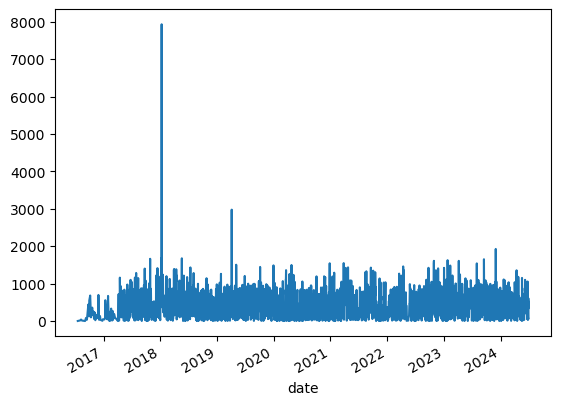

In [34]:
from counting_boats.boat_utils.image_cutting_support import create_unpadded_png
import subprocess
import pathlib
ARCHIVE_DIR = "U:\\Research\\Projects\\sef\\livingplayingmb\\Boat Detection TMBF\\PlanetArchive"
# all zips are of form 'moreton_YYYYMMDD.zip'
def show_image_for_date(date, delete=True):
    zip_name = f"moreton_{date.replace('-', '')}.zip"
    # get the zip file from the archive 
    zip_path = os.path.join(ARCHIVE_DIR, zip_name)
    # make sure spaces are safe for child process
    # extract the zip file
    # unzip the file to this directory:
    unzip_dir = "D:/temp"
    print(f"unzipping {zip_path} to {unzip_dir}")
    result = subprocess.run(f'powershell -command "Expand-Archive -Path \'{zip_path}\' -DestinationPath {unzip_dir} -Force"',
                            capture_output=True, text=True, shell=True)
    print(result.stdout)
    print(result.stderr)

    if result.returncode != 0:
        raise ChildProcessError("Unzip failed")
    # get the image file
    print(f"Creating PNG")
    create_unpadded_png(unzip_dir, unzip_dir, "composite.tif")
    # show the image with matplotlib
    image = plt.imread(os.path.join(unzip_dir, "composite.png"))
    plt.imshow(image)
    plt.show()
    # delete the directory
    if delete:
        os.system(f"rm -rf {unzip_dir}")

# normalise boat detections each day by coverage
daily_counts = detections["date"].value_counts().sort_index()
normalized_counts_daily = daily_counts  #/ coverage.groupby("date")["area_coverage"].sum()
normalized_counts_daily.plot()
# find outliers
Q1 = normalized_counts_daily.quantile(0.25)
Q3 = normalized_counts_daily.quantile(0.75)
IQR = Q3 - Q1

print(f"Q1: {Q1}, Q2: {Q3}, IQR: {IQR}")

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = normalized_counts_daily[(normalized_counts_daily < lower_bound) | (normalized_counts_daily > upper_bound)]

print("Outliers:")
print(outliers)








In [72]:
# sort outliers by how much they are outliers
outliers = outliers.sort_values(key=lambda x: abs(x - normalized_counts_daily.mean()), ascending=False)
print("Sorted outliers:")
print(outliers)
# show_image_for_date(outliers.index[0].strftime('%Y-%m-%d'), delete=True)


Sorted outliers:
date
2018-01-10    7938
2018-01-08    3356
2019-04-06    2979
2018-04-14    2772
2017-07-22    2460
2018-04-16    2446
2017-07-29    2200
2018-04-15    2142
2017-07-24    1944
2017-07-26    1934
2018-01-07    1924
2018-01-05    1912
2017-08-28    1860
2017-05-15    1802
2017-07-28    1780
2017-08-31    1688
2018-05-20    1681
2017-10-28    1666
2017-07-20    1652
Name: count, dtype: int64
unzipping U:\Research\Projects\sef\livingplayingmb\Boat Detection TMBF\PlanetArchive\moreton_20180110.zip to D:/temp


Creating PNG


MemoryError: Unable to allocate 9.20 GiB for an array with shape (41641, 14830, 4) and data type float32

<Figure size 640x480 with 1 Axes>

In [36]:
# on subplots, plot the total boats detected per week as bars, one plot per year. Do stacked bars, with weekday/weekend as different colours
# Aggregate data
detections['week'] = detections['date'].dt.isocalendar().week
detections['year'] = detections['date'].dt.year
detections['is_weekend'] = detections['date'].dt.dayofweek >= 5 # 5 and 6 are Saturday and Sunday

grouped_counts = detections.groupby(['year', 'week', 'is_weekend']).size()

grouped_counts.head()


year  week  is_weekend
2016  29    False          2
      31    False         17
      32    False         41
      33    False         13
      35    False          4
dtype: int64

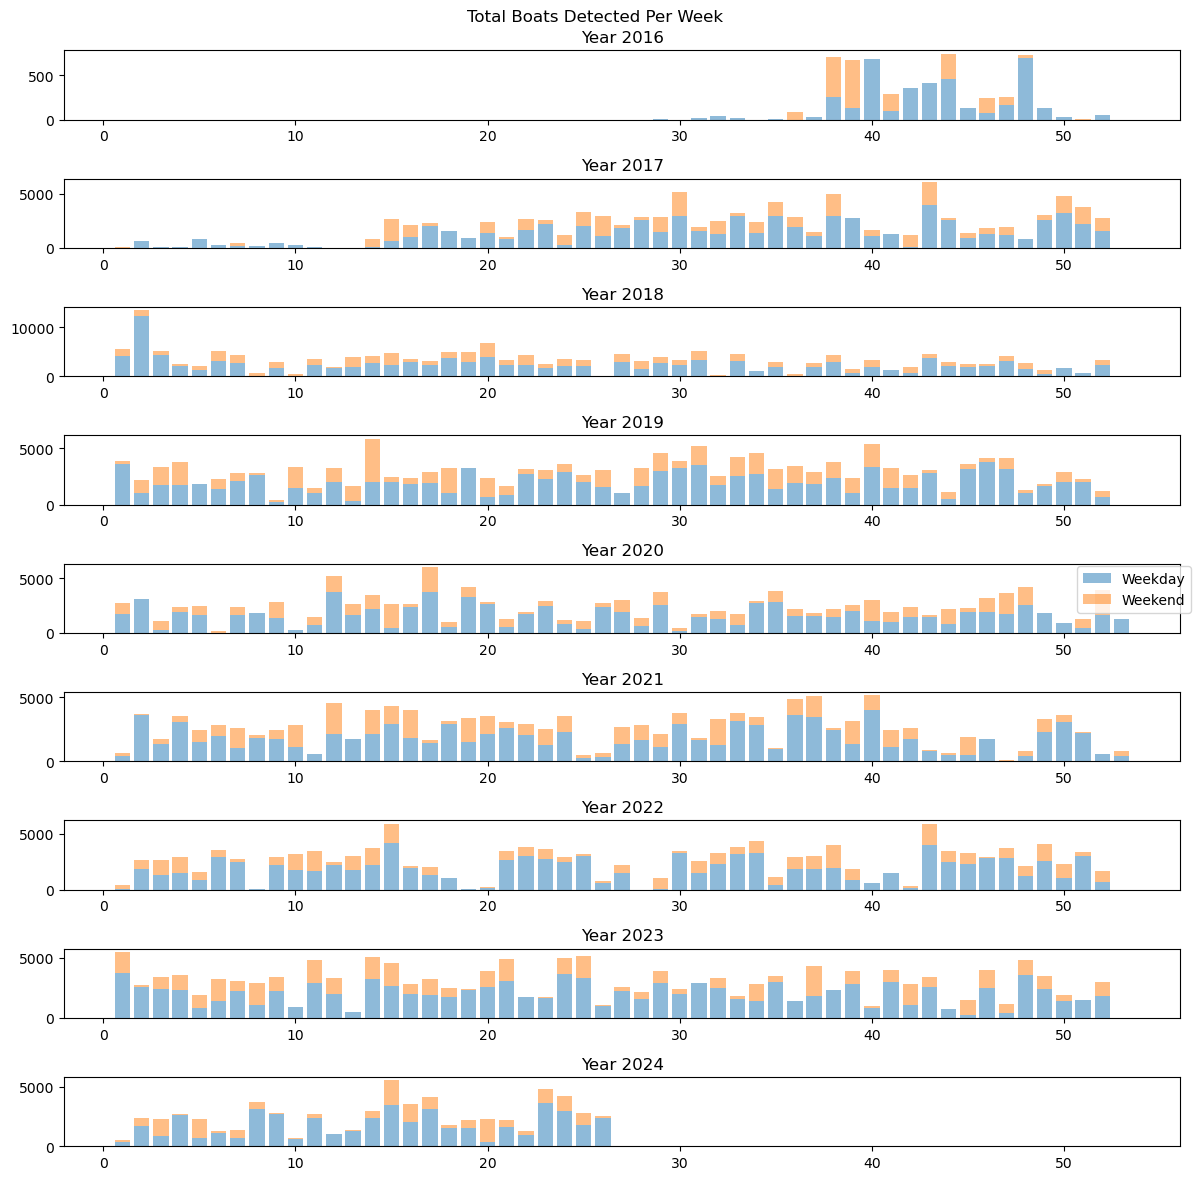

In [37]:

# Plot
fig, axs = plt.subplots(9, 1, figsize=(12, 12))
for i, year in enumerate(range(2016, 2024 + 1)):
    bottom = np.zeros(53)
    for j, weekend in enumerate([False, True]):
        data = grouped_counts[year].loc[:, weekend, :] # this is a series with week, and value
        # make sure data has all weeks, and fill in missing weeks with 0
        data = data.reindex(range(1, 54), fill_value=0)
        ax = axs[i]
        ax.bar(data.index, data.values, label='Weekend' if weekend else 'Weekday', alpha=0.5, bottom=bottom)
        bottom += data.values
        ax.set_title(f"Year {year}")
# use one legend fot the whole plot with Weekday and Weekendk
fig.legend(['Weekday', 'Weekend'], loc='center right')
# add title
fig.suptitle("Total Boats Detected Per Week")
plt.tight_layout()
plt.show()







In [ ]:
# plot the number of boats detected per month, only including days where over 90% coverage

# get the coverage for each day
coverage['month'] = coverage['date'].dt.month
coverage['year'] = coverage['date'].dt.year
